# LeNet 5

We demonstrate the various steps involved in implementing a LeNet 5 model with sinabs. This tutorial will have the following steps.

1. Build/define CNN and SNN models.
2. Load weights.
3. Load data.
4. Tuning/scaling the parameters for the SNN.


We first start by importing all necessary libraries.

In [1]:
# Import all libraries
from __future__ import print_function

import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import sinabs.layers as sl
import sinabs

## Define CNN model

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

## Define equivalent SNN model

We can now define an equivalent SNN model by using the SNN equivalent layers which are conveniently named as `Spiking<Operation>Layer` in `sinabs`.

In [3]:
class MySNN(nn.Module):
    def __init__(self):
        super(MySNN, self).__init__()
        # Spiking Input Layer
        self.input_1 = sl.InputLayer(input_shape=(1, 28, 28), layer_name="input_1")

        # Spiking Conv layer
        self.conv1 = sl.SpikingConv2dLayer(
            channels_in=1,
            image_shape=(28, 28),
            channels_out=20,
            kernel_shape=(5, 5),
            layer_name="conv1",
            strides=(1,1),
        )

        # Spiking SumPooling layer
        self.pool1 = sl.SpikingMaxPooling2dLayer(
            image_shape=(24, 24), pool_size=(2, 2), layer_name="pool1"
        )

        # Spiking Conv layer
        self.conv2 = sl.SpikingConv2dLayer(
            channels_in=20,
            image_shape=(12, 12),
            channels_out=50,
            kernel_shape=(5, 5),
            layer_name="conv2",
        )

        # Spiking SumPooling layer
        self.pool2 = sl.SpikingMaxPooling2dLayer(
            image_shape=(8, 8), pool_size=(2, 2), layer_name="pool2"
        )

        # Generating an Equivalent Spiking Dense Layer
        # This layer emulates flatten+dense layer        
        self.fc1= sl.SpikingConv2dLayer(channels_in=50,
                                         image_shape=(4,4),
                                         channels_out=500,
                                         kernel_shape=(4,4),
                                         strides=(4,4),
                                         layer_name='fc1'
                                        )
        self.fc2 = sl.SpikingConv2dLayer(channels_in=500,
                                 image_shape=(1,1),
                                 channels_out=10,
                                 kernel_shape=(1,1),
                                 strides=(1,1),
                                 layer_name='fc2'
                                )
        

    def forward(self, x):
        # Define your graph
        x = self.input_1(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        #x = self.flatten1(x)
        x = self.fc1(x)
        out = self.fc2(x)
        return out

`NOTE` : When assigning `layer_name` in your model, use the same name as the variable name assigned in the module. The naming is used to identify the layers when comparing CNN with SNN in `sinabs`.

### Initialize the spiking model and  encapsulate into Network object 

In [4]:
snn = sinabs.Network()
snn.spiking_model = MySNN()

In [5]:
snn.summary()

/home/sadique/Work/aictx/sinabs/sinabs/network.py:381: UserWarning: Graph couldn't be inferred by sinabs. Perhaps you have defined a custom model.
  "Graph couldn't be inferred by sinabs. Perhaps you have defined a custom model."


,Bias_Params,Fanout_Prev,Input_Shape,Kernel_Params,Neurons,Output_Shape,Type,Kernel,Padding,Stride,Pooling
Layer,,,,,,,,,,,
input_1,0.0,1.0,"(1, 28, 28)",0.0,0.0,"(1, 28, 28)",InputLayer,NaN,NaN,NaN,NaN
conv1,20.0,500.0,"(1, 28, 28)",500.0,11520.0,"(20, 24, 24)",SpikingConv2dLayer,"(5, 5)","(0, 0, 0, 0)","(1, 1)",NaN
pool1,0.0,1.0,"(None, 24, 24)",0.0,0.0,"(None, 12, 12)",SpikingMaxPooling2dLayer,"(2, 2)","(0, 0, 0, 0)","(2, 2)","(2, 2)"
conv2,50.0,1250.0,"(20, 12, 12)",25000.0,3200.0,"(50, 8, 8)",SpikingConv2dLayer,"(5, 5)","(0, 0, 0, 0)","(1, 1)",NaN
pool2,0.0,1.0,"(None, 8, 8)",0.0,0.0,"(None, 4, 4)",SpikingMaxPooling2dLayer,"(2, 2)","(0, 0, 0, 0)","(2, 2)","(2, 2)"
fc1,500.0,500.0,"(50, 4, 4)",400000.0,500.0,"(500, 1, 1)",SpikingConv2dLayer,"(4, 4)","(0, 0, 0, 0)","(4, 4)",NaN
fc2,10.0,10.0,"(500, 1, 1)",5000.0,10.0,"(10, 1, 1)",SpikingConv2dLayer,"(1, 1)","(0, 0, 0, 0)","(1, 1)",NaN


## Initialize an equivalent CNN model and encapsulate it to the network object

In [6]:
cnn_net = CNN()
cnn_net.load_state_dict(torch.load("./mnist_cnn.pt"))

# Add a reference to the CNN model to the Network object
snn.analog_model = cnn_net

Adding a reference to the equivalent CNN model in the Network object allows several methods in `Network` object. One such method is the `set_weights` method.

## Load weights to your model

Let us examine some of the parameters of the SNN and CNN models we initialized.

In [7]:
weights = cnn_net.state_dict()
print(weights.keys())
print("=======================")
print(list(snn.spiking_model.parameters())[1])

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
Parameter containing:
tensor([-0.0847, -0.0368, -0.0393,  0.1194,  0.0671, -0.0623, -0.0644,  0.0233,
         0.1963,  0.0918, -0.1171,  0.1657, -0.0825,  0.0382, -0.0547, -0.0136,
         0.1462, -0.1023,  0.0438,  0.0394], requires_grad=True)


We will now transfer the weights of the CNN model to the SNN model. To do this, we first extract the weights of the CNN model into a list of numpy arrays holding all the parameters.

In [8]:
# Extract weights from CNN model
weights = [p.detach().numpy() for p in cnn_net.parameters()]

### Load weights to both CNN and SNN models

In [9]:
snn.set_weights(weights)

Lets have a look at the biases of the first layer in the analog and CNN model. 
NOTE: We set `auto_rescale` here to `False`. We will see what parameter means later in this tutorial. 
Usually we want this parameter to be set to `True`. It is set to `False` only for illustrative purposes of this tutorial.

In [10]:
print(list(snn.spiking_model.parameters())[1])

Parameter containing:
tensor([-1.2348e-01, -1.4768e-01, -1.7782e-01, -5.0483e-02, -3.9126e-02,
        -9.7103e-02, -1.0429e-04, -9.4956e-02,  2.7214e-02, -1.4487e-03,
        -1.0568e-01,  2.2480e-02, -9.4489e-02,  2.1322e-01,  7.6859e-02,
        -1.7281e-01,  2.0359e-03, -6.6384e-02, -1.5167e-01, -9.1698e-03],
       requires_grad=True)


In [11]:
print(list(cnn_net.parameters())[1])

Parameter containing:
tensor([-1.2348e-01, -1.4768e-01, -1.7782e-01, -5.0483e-02, -3.9126e-02,
        -9.7103e-02, -1.0429e-04, -9.4956e-02,  2.7214e-02, -1.4487e-03,
        -1.0568e-01,  2.2480e-02, -9.4489e-02,  2.1322e-01,  7.6859e-02,
        -1.7281e-01,  2.0359e-03, -6.6384e-02, -1.5167e-01, -9.1698e-03],
       requires_grad=True)


As you can see, the parameters have been successfully transferred from the analog model to the spiking model.

# Generate input for the spiking model and analog model

Let us start by define a dataset for MNIST images. 
Our dataset generator will generate spikes or images depending on the initialization flag.

In [12]:
import numpy as np
from PIL import Image
class MNIST_Dataset(datasets.MNIST):
    
    def __init__(self, root, train = True, spiking=False, tWindow=100):
        datasets.MNIST.__init__(self, root, train=train, download=True)
        self.spiking=spiking
        self.tWindow = tWindow

    
    def __getitem__(self, index):
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        if self.spiking:
            img = (np.random.rand(self.tWindow, 1, *img.size()) < img.numpy()/255.0).astype(float)
            img = torch.from_numpy(img).float()
        else:
            # doing this so that it is consistent with all other datasets
            # to return a PIL Image
            img = torch.from_numpy(img.numpy()).float()
            img.unsqueeze_(0)
            
        return img, target

In order to test the accuracy of our model, we first define a convenience method to test and present its performance accuracy.

In [13]:
import warnings

# Convenience method to test the model
def test(model, data_loader, num_batches=None):
    model.eval()
    test_loss = 0
    correct = 0
    batch_count = 0
    
    with torch.no_grad():
        # Iterate over data
        for data, target in data_loader:
            if data_loader.dataset.spiking:
                if len(data.size()) > 4:
                    warnings.warn("Warning: Batch size needs to be 1, only first sample used.")
                    data = data[0]
                    target = target[0]
            output = model(data)
            if data_loader.dataset.spiking:
                output = output.sum(0).squeeze().unsqueeze(0)
                target = target.unsqueeze(0)
            # Add loss to the total loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Compute the total correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            batch_count += 1
            if (batch_count*data_loader.batch_size)%500 == 0:
                print(f"Accuracy : {correct/(batch_count*data_loader.batch_size):.4f} for {batch_count*data_loader.batch_size} samples")
            if num_batches:
                if num_batches <= batch_count: break;
       
    # Total samples:
    num_data = (batch_count*data_loader.batch_size)
    # Compute final loss
    test_loss /= num_data

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, num_data,
        100. * correct / num_data))



Let us first test the CNN model

In [14]:
# Define test dataset loader
test_loader = torch.utils.data.DataLoader(
    MNIST_Dataset('./data', train=False, spiking=False),
    batch_size=5, shuffle=False)

In [15]:
test(cnn_net, test_loader)

Accuracy : 0.9860 for 500 samples
Accuracy : 0.9840 for 1000 samples


/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy : 0.9793 for 1500 samples
Accuracy : 0.9795 for 2000 samples
Accuracy : 0.9776 for 2500 samples
Accuracy : 0.9780 for 3000 samples
Accuracy : 0.9789 for 3500 samples
Accuracy : 0.9785 for 4000 samples
Accuracy : 0.9778 for 4500 samples
Accuracy : 0.9774 for 5000 samples
Accuracy : 0.9791 for 5500 samples
Accuracy : 0.9798 for 6000 samples
Accuracy : 0.9812 for 6500 samples
Accuracy : 0.9820 for 7000 samples
Accuracy : 0.9832 for 7500 samples
Accuracy : 0.9842 for 8000 samples
Accuracy : 0.9848 for 8500 samples
Accuracy : 0.9856 for 9000 samples
Accuracy : 0.9859 for 9500 samples
Accuracy : 0.9857 for 10000 samples

Test set: Average loss: -0.9857, Accuracy: 9857/10000 (99%)



Now let us repeat this on the SCNN model

In [16]:
# Time window per sample
tWindow = 50 # ms (or) time steps

# Define test dataset loader
test_spike_loader = torch.utils.data.DataLoader(
    MNIST_Dataset('./data', train=False, spiking=True, tWindow=tWindow),
    batch_size=1, shuffle=False)

NOTE: 
The following simulation run is going to be very slow. After a few iterations, the accuracy should stablize. 
Once you get a sense of the performance of the model. Just stop the run (stop button on notebook)

In [17]:
test(snn, test_spike_loader, num_batches=200)

/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Warning: Batch size needs to be 1, only first sample used.
  from ipykernel import kernelapp as app



Test set: Average loss: -1722.3600, Accuracy: 199/200 (100%)



You will see a reasonable accuracy for the spiking model with equivalent performance to that of the CNN.

Go to the bottom of this example to read a few pointers on how you can improve the performance of the network.

You can get a synopsis of the total synaptic operations of this network by calling the `get_synops` method of the `Network` object.

In [18]:
snn.get_synops(num_evs_in=-1)

,Events_routed,Fanout_Prev,In,Layer,Out,SynOps,SynOps/s,Time_window
0,-1.0,1.0,-1.0,input_1,7461.0,0.0,0.000000e+00,50.0
1,3730500.0,500.0,7461.0,conv1,99752.0,3730500.0,7.461000e+07,50.0
2,99752.0,1.0,99752.0,pool1,41811.0,0.0,0.000000e+00,50.0
3,52263750.0,1250.0,41811.0,conv2,54483.0,52263750.0,1.045275e+09,50.0
4,54483.0,1.0,54483.0,pool2,30223.0,0.0,0.000000e+00,50.0
5,15111500.0,500.0,30223.0,fc1,52566.0,15111500.0,3.022300e+08,50.0
6,525660.0,10.0,52566.0,fc2,3887.0,525660.0,1.051320e+07,50.0


Now let us look at the accuracy of the SNN on the complete dataset.

In [19]:
test(snn, test_spike_loader)

/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Warning: Batch size needs to be 1, only first sample used.
  from ipykernel import kernelapp as app


Accuracy : 0.9880 for 500 samples
Accuracy : 0.9840 for 1000 samples
Accuracy : 0.9800 for 1500 samples
Accuracy : 0.9795 for 2000 samples
Accuracy : 0.9788 for 2500 samples
Accuracy : 0.9793 for 3000 samples
Accuracy : 0.9797 for 3500 samples
Accuracy : 0.9792 for 4000 samples
Accuracy : 0.9787 for 4500 samples
Accuracy : 0.9776 for 5000 samples
Accuracy : 0.9793 for 5500 samples
Accuracy : 0.9800 for 6000 samples
Accuracy : 0.9814 for 6500 samples
Accuracy : 0.9817 for 7000 samples
Accuracy : 0.9828 for 7500 samples
Accuracy : 0.9839 for 8000 samples
Accuracy : 0.9845 for 8500 samples
Accuracy : 0.9852 for 9000 samples
Accuracy : 0.9855 for 9500 samples
Accuracy : 0.9854 for 10000 samples

Test set: Average loss: -1733.4155, Accuracy: 9854/10000 (99%)



## Debugging tools

The library provides some handy tools to verify the activity of the SNN network and compare it to CNN activations. The key method that allows you to do this is the `Netowrk.compare_activations()` method. This method returns the activations of any layer of interest form both CNN and SNN models.

The `Network.plot_comparison()` plots the activations of both versions of the network in an understandable figure.

In [20]:
import pylab
%matplotlib notebook

['conv1', 'conv2', 'fc1', 'fc2']


/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/sadique/Work/aictx/sinabs/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


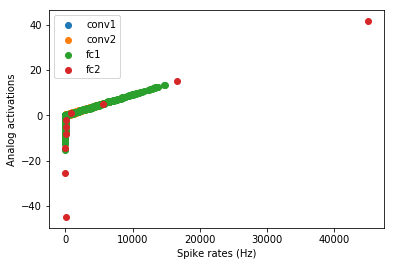

In [21]:
# Generate data to use
for data, label in test_spike_loader:
    break;
 
cnn_act, spk_act = snn.plot_comparison(data[0], compute_rate=True, name_list=['conv1', 'conv2', 'fc1', 'fc2'])

As you can see in the above figure, the activation of CNN and SNN fall on the $x=y$ diagonal line. This is the ideal case where the activity of the SNN faithfully replicates the CNN network. (The negative activations are not identical because of ReLu activation of the layers.

## Factors influencing performance.

If you see disappointing results or just about chance level accuracy, this might be due to several reasons.

When you flatten the activity of your model, you need to be extremely cautious about order in which the layer activations are ordered. You will need to ensure that the ordering of the trained model is consistent with the SNN.

It could be that the activity levels are very low and you need to `rescale` your weights when you set them for the spiking model. This happends when using pooling layers since in the spiking models, we use `SumPooling` in place of `AveragePooling`. 